# Figure 9: Annotations vs. CoCiP

This code will run CoCiP for all collocations in the final dataset. Running this the first time takes quite a while since the ERA5 weather data will be downloaded to your cache. I already downloaded this, and saved the data necessary data to [data/contrail_evolution/](../../data/contrail_evolution/). To run this on other flights, uncomment the part where the CoCiP simulations are run. Note, you do need the full dataset to access the IAGOS flight information for running CoCiP. 

In [10]:
import json
import os
import warnings
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns
import pyproj
from shapely.geometry import shape, mapping
from shapely.ops import transform

from pycontrails import Flight
from pycontrails.datalib import sentinel
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.datalib.leo_utils import correction
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import ConstantHumidityScaling
from pycontrails.models.ps_model import PSFlight

from comop.meteo.isa import get_p_ISA
from iagos_toolkit.flight.aircraft_performance import create_flight_from_iagos

In [11]:
DATASET_LOCATION = "../../data/collocations/" # Change to None when plotting without dataset. This will not render the flight tracks

df = pd.read_csv('../../data/landsat_sentinel_collocations_20260212.csv', comment='#')

In [12]:
df = df[df["air_temperature_iagos_validity"] <= 0]
df = df[df["rhl_iagos_validity"] <= 0]
df = df[df["contrail_formation"].notna()]
df = df[df["efficiency_PS_IAGOS"].notna()]

df = df[df["satellite"] == "Sentinel"]
df = df[df["contrail_formation"] == True]
df = df[df["contrail_label"].notna()]

print("Number of annotated cases in Sentinel-2:", len(df))

Number of annotated cases in Sentinel-2: 195


In [13]:
# def round_pressure_levels(levels):
#     supported_levels = np.array([
#         1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750,
#         700, 650, 600, 550, 500, 450, 400, 350, 300, 250, 225,
#         200, 175, 150, 125, 100, 70, 50, 30, 20, 10, 7, 5, 3, 2, 1, -1
#     ])

#     lower_bound = min(levels)
#     lower_levels = supported_levels[supported_levels <= lower_bound]

#     upper_bound = max(levels)
#     upper_levels = supported_levels[supported_levels >= upper_bound]

#     return [lower_levels.max(), upper_levels.min()]

In [14]:
# def get_cocip_contrail(flight, target_time, window=[-10, 1], dt_integration=1, rh_scaling=0.99):
#     # convert flight to dataframe
#     flight_df = flight.dataframe

#     # Define time window
#     start_time = target_time + pd.Timedelta(minutes=window[0]) - pd.Timedelta(seconds=4) # subtract 4 seconds minute buffer
#     end_time = target_time + pd.Timedelta(minutes=window[1]) + pd.Timedelta(minutes=1) # add 21 minute buffer after to avoid no Met error

#     # Trim the flight
#     flight_df_trimmed = flight_df[(flight_df["time"] >= start_time) & (flight_df["time"] <= end_time)].copy()
#     flight_df_trimmed.reset_index(drop=True, inplace=True)

#     flight_trimmed = Flight(flight_df_trimmed, attrs=flight.attrs).clean_and_resample("1s")
    
#     # get meteorlogical data
#     time_bounds = (flight_trimmed.time_start, flight_trimmed.time_end)
#     pressure_levels = round_pressure_levels([get_p_ISA(flight_df_trimmed["altitude"].max()) / 100, get_p_ISA(flight_df_trimmed["altitude"].min()) / 100])

#     era5pl = ERA5(
#         time=time_bounds,
#         variables=Cocip.met_variables + Cocip.optional_met_variables,
#         pressure_levels=pressure_levels,
#     )
#     era5sl = ERA5(time=time_bounds, variables=Cocip.rad_variables)

#     # download data from ERA5 (or open from cache)
#     met = era5pl.open_metdataset()
#     rad = era5sl.open_metdataset()

#     params = {
#         "dt_integration": np.timedelta64(dt_integration, "s"),
#         "humidity_scaling": ConstantHumidityScaling(rhi_adj=rh_scaling),
#         "aircraft_performance": PSFlight(),
#         "max_age": pd.Timedelta(minutes=(-window[0] + window[1])),
#     }
#     cocip = Cocip(met=met, rad=rad, params=params)

#     _ = cocip.eval(source=flight_trimmed)
#     contrail_df = cocip.contrail
#     if contrail_df is None or contrail_df.empty:
#         return pd.DataFrame()  # Return empty DataFrame if no contrail data
#     contrail_df = contrail_df[contrail_df["time"] == target_time]
    
#     return contrail_df

In [ ]:
# for idx, row in tqdm(df.iterrows(), "Running CoCiP for all annotated contrails", total=len(df)):
    
#     intersect_directory = DATASET_LOCATION + row["path"]
#     # print(intersect_directory)
    
#     # Manually labelled aircraft location
#     x_ac = row["x"]
#     y_ac = row["y"]

#     flight = create_flight_from_iagos(
#         f"{intersect_directory}/{row['iagos_file']}", "A333"
#     )
#     target_time = pd.to_datetime(row["sensing_time"])
#     target_time = target_time.round("1s").tz_localize(None)

#     handler = sentinel.Sentinel(row["base_url"], row["scene_id"], bands=["B02", "B03", "B04"])
    
#     # rh_scaling = 0.99  # Teoh value
#     iagos_rh = row["rhi_iagos"]
#     era5_rh = row["rhi_era5"]
#     rh_scaling = era5_rh / iagos_rh   

#     # clip between realistic values
#     rh_scaling = max(0.7, min(rh_scaling, 1.3))

#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore", UserWarning)
    
#         cocip_df = get_cocip_contrail(flight, target_time, window=[-20, 1], rh_scaling=rh_scaling)

#     if cocip_df.empty:
#         cocip_df.to_csv(f"../../data/contrail_evolution/cocip/{row['scene_id']}_rh_variable.csv")
#         continue

#     # add the x and y coordinates of the contrail in the UTM coordinate system
#     utm_crs = handler.get_crs()

#     # Project from WGS84 to the x and y coordinates in the UTM coordinate system
#     transformer = pyproj.Transformer.from_crs("EPSG:4326", utm_crs, always_xy=True)
#     x1, y1 = transformer.transform(cocip_df["longitude"], cocip_df["latitude"])
#     z = cocip_df.altitude

#     cocip_df.loc[:, "x"] = x1
#     cocip_df.loc[:, "y"] = y1

#     # Apply sensing angle correction
#     ds_angles = handler.get_viewing_angle_metadata()
#     x_proj, y_proj = correction.scan_angle_correction(ds_angles, x1, y1, z, maxiter=3)
#     cocip_df.loc[:, "x_proj"] = x_proj
#     cocip_df.loc[:, "y_proj"] = y_proj

#     # print(f"Processed granule: {granule_id}. Found {len(cocip_df)} contrail points.")
#     cocip_df.to_csv(f"../../data/contrail_evolution/cocip/{row['scene_id']}_rh_variable.csv")

---
## Plotting the figure

In [16]:
input_dir = "../../data/contrail_evolution/annotations"

contrails = {}

for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        scene_id = filename.replace(".json", "")
        
        with open(os.path.join(input_dir, filename)) as f:
            data = json.load(f)

        # Convert lists back to numpy arrays where needed
        for key in ["x", "y", "distance", "width", "age"]:
            if key in data:
                data[key] = np.array(data[key])

        contrails[scene_id] = data


Case 1 statistics:
  Slope (observations): 1.7018 m/s
  Slope (CoCiP):        1.5248 m/s

Case 2 statistics:
  Slope (observations): 0.9332 m/s
  Slope (CoCiP):        0.5823 m/s

Case 3 statistics:
  Slope (observations): 0.8202 m/s
  Slope (CoCiP):        0.8094 m/s


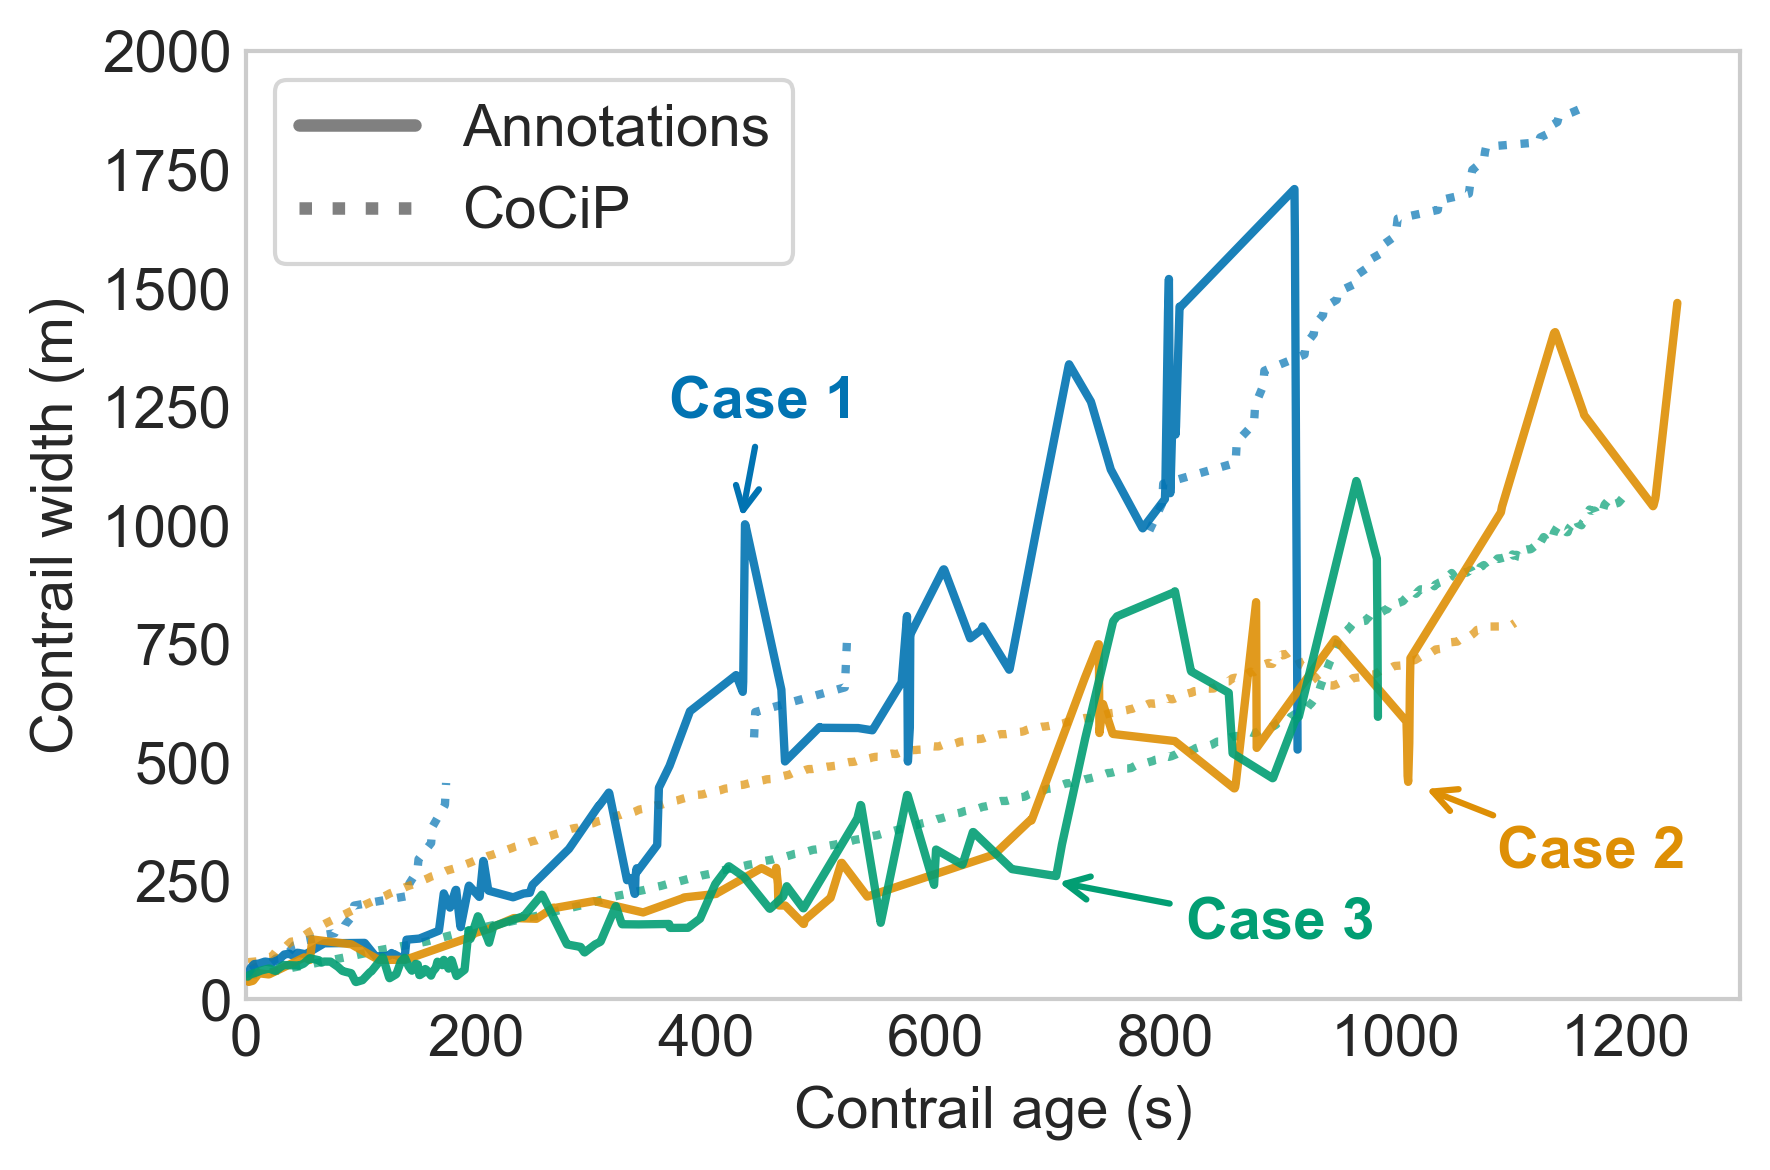

In [17]:
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

plt.style.use("seaborn-v0_8-whitegrid")  # Seaborn-like style without seaborn

window = 21  # smoothing window (must be odd)
case_colors = sns.color_palette("colorblind", 3)
color_cycle = itertools.cycle(case_colors)

annotation_locations = [
    [430, 1000, 450, 1200],
    [1020, 450, 1170, 250],
    [700, 250, 900, 100],
]

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
case_idx = 1

for d in contrails.values():
    # Only keep long-lived contrails
    if d["total_age"] <= 600:
        continue

    color = next(color_cycle)
    
    # Load CoCiP
    cocip = pd.read_csv(f"../../data/contrail_evolution/cocip/{d['scene_id']}_rh_variable.csv")
    cocip["age_seconds"] = pd.to_timedelta(cocip["age"]).dt.total_seconds().astype(int)
    cocip = cocip[cocip["age_seconds"] >= 1]
    cocip.sort_values("age_seconds", inplace=True)
    cocip["width_smooth"] = cocip["width"].rolling(window=window, center=True, min_periods=1).mean()

    # Observations
    annotation = pd.DataFrame({
        "age": pd.to_numeric(d["age"], errors="coerce"),
        "width": pd.to_numeric(d["width"], errors="coerce"),
    })

    # Drop NaNs
    annotation = annotation.dropna(subset=["width"]).sort_values("age")
    
    # Plot annotations
    ax.plot(
        annotation["age"],
        annotation["width"],
        color=color,
        linewidth=2,
        alpha=0.9,
        linestyle="-",
        zorder=3,
    )

    # Plot CoCiP 
    x = cocip["age_seconds"].values
    y = cocip["width_smooth"].values
    gap_mask = np.diff(x) > 100  # detect large gaps
    y_plot = y.astype(float).copy()
    y_plot[1:][gap_mask] = np.nan  # insert NaNs after gaps

    ax.plot(
        x,
        y_plot,
        color=color,
        linewidth=2.0,
        alpha=0.7,
        linestyle="dotted",
        zorder=2,
    )

    # Add annotation arrows
    ann = annotation_locations[case_idx - 1]
    ax.annotate(
        f"Case {case_idx}",
        xy=(ann[0], ann[1]),
        xytext=(ann[2], ann[3]),
        arrowprops=dict(arrowstyle="->", color=color, lw=1.5),
        fontsize=14,
        color=color,
        ha="center",
        va="bottom",
        fontweight="bold"
    )

    slope_ann, _ = np.polyfit(annotation["age"], annotation["width"], deg=1)
    slope_cocip, _ = np.polyfit(cocip["age_seconds"], cocip["width_smooth"], deg=1)

    print(f"\nCase {case_idx} statistics:")
    print(f"  Slope (observations): {slope_ann:.4f} m/s")
    print(f"  Slope (CoCiP):        {slope_cocip:.4f} m/s")

    case_idx += 1

# Add legend for line styles
ax.plot([], [], color="grey", linewidth=3, linestyle="-", label="Annotations")
ax.plot([], [], color="grey", linewidth=3, linestyle="dotted", label="CoCiP")

# Axis formatting
ax.set_xlabel("Contrail age (s)")
ax.set_ylabel("Contrail width (m)")
ax.set_xlim(0, 1300)
ax.set_ylim(0, 2000)
ax.legend(frameon=True, fontsize=14, loc="upper left")
ax.grid(False)
plt.tight_layout()
plt.savefig("figures/fig09.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()